In [12]:
import networkx as nx
import numpy as np
import helper_functions as hf 
COLORS="brgymcbrgymc"

import importlib
importlib.reload(hf)

import problem as pr
importlib.reload(pr)

<module 'problem' from '/home/lema/Documents/diplomska/problem.py'>

[(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)]
[[1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]] [[1. 1. 0. 0.]
 [0. 0. 1. 1.]] [1, 1, 1, 1, 1, 1, 1] [1, 2, 1, 4, 5, 6, 7] [1, 1]
[(1, 3), (3, 5), (5, 6)]
[(1, 3), (3, 4), (4, 5), (5, 6)]
[(3, 5), (2, 3), (5, 7)]
[(3, 4), (2, 3), (4, 5), (5, 7)]


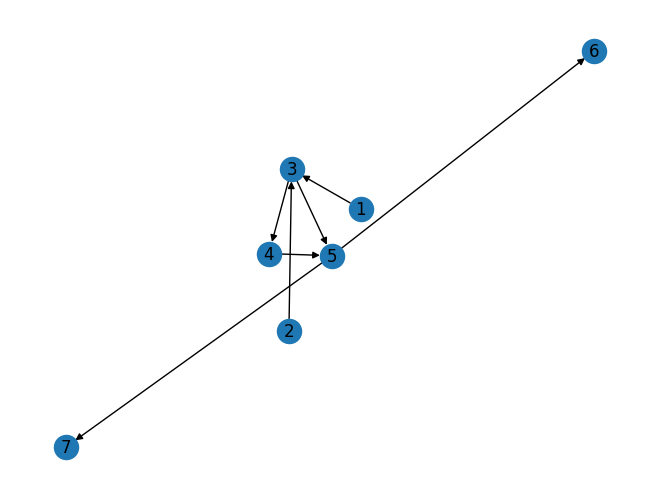

In [2]:

G = nx.DiGraph()
# G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7),(3,1),(3,2),(4,3),(5,4),(5,3),(6,5),(7,5)])
G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7)])


print(G.edges())
#nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 'c')
nx.set_edge_attributes(G, {e: (i+1) for i,  e in enumerate(G.edges())}, name = 'c')
nx.set_edge_attributes(G, {(3,5):1}, name = 'c')
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 't')
x = list(G.edges)

nx.draw(G,with_labels=True)

ZK = [(1,6,1),(2,7,1)] # z,k,a

Q,B,t,c,a = hf.sestavi_QBtca(ZK, G)
print(Q,B,t,c,a)

for i in range(Q.shape[1]):
    print(hf.binary_vector_to_edges(Q[:,i],G.edges()))

        


In [10]:
#c = [1, 3, 1, 1, 3, 1, 3]
#t = [1, 1, 1, 1, 0.5, 1, 1]
#Q = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1]]
#B = [[1, 1, 0, 0], [0, 0, 1, 1]]


paths = hf.poklici_linprog(ZK,G)


12.0 [1. 0. 1. 0.] Optimization terminated successfully. (HiGHS Status 7: Optimal)


8.0 [1. 0. 1. 0.] Optimization terminated successfully. (HiGHS Status 7: Optimal)
[[(1, 3), (3, 4), (4, 5), (5, 6)], [(3, 4), (2, 3), (4, 5), (5, 7)]]


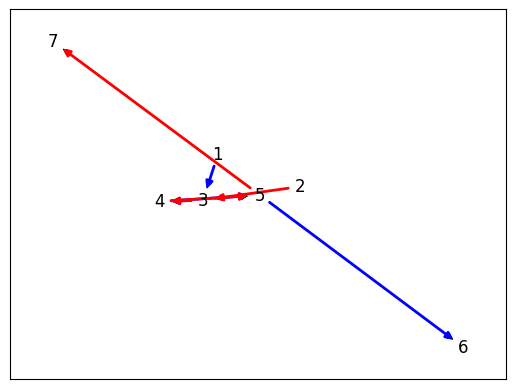

In [31]:
paths = hf.poklici_linprog(ZK,G,edges_mode=True)
hf.my_nx_draw(G,paths,with_labels=True,with_nodes=False)
print(paths)

In [43]:
# problematicen je izbor zacetnega priblizka, vecinoma se zatekne v lokalnem minimumu
# kako vpeljat da gresta 2 avta po neki poti? TODO
# bolj pameten zacetni priblizek
import numpy as np
from scipy.optimize import minimize

# Definiramo funkcijo, ki jo želimo minimizirati
t = np.array([[1,1,30,1,1,1,1]]).T
c = np.array([[1,1,1,1,1,1,1]]).T * 2
ZK = [(1,6,1),(2,7,1)]
def poklici_minimize(ZK,c,t):
    M = hf.sparse_incidence_matrix(G.nodes(),G.edges())
    
    a = [a for _,_,a in ZK]
    M_ZK = hf.sparse_incidence_matrix(G.nodes(),[(z,k) for z, k, _ in ZK],factor=a)
    
    def f(x):
        X = x.reshape(len(t),len(ZK))
        return np.sum(t.T@X)

    # X0 = np.array([[1,0],[0,0],[1,1],[0,1],[0,0],[1,0],[0,1]])
    # x0 = X0.reshape(-1)
    x0 = np.random.rand(len(t) * len(ZK)) #* max(a)
    print(x0)

    # Definiramo omejitve, če so potrebne (npr. X mora biti pozitiven)
    #X >= 0

    constraints = []
    constraints =  [{'type': 'ineq', 'fun': lambda x: x}]
    def con1(x):
        X = x.reshape(len(t),len(ZK))
        m = len(ZK)
        unit = np.ones((m, 1))
        r = c - X@unit
        return np.repeat(r,x.size//r.size)
    constraints.append({'type': 'ineq', 'fun': con1})
    def con2(x):
        X = x.reshape(len(t),len(ZK))
        r = M@X - M_ZK
        r = r.reshape(-1)
        return np.repeat(r,x.size//r.size)
    constraints.append({'type': 'eq', 'fun': con2})
    print(constraints)
    res = minimize(f, x0, method='SLSQP', constraints=constraints, bounds=np.array((np.zeros(x0.size),np.ones(x0.size))).T)

    # Izpišemo optimalno rešitev
    print('(NE)Optimalna rešitev:')
    print(res.x, res.fun, res.message, res.success)


    def smart_round(x):
        x[x > 0.5] = 1
        x[x < 0.5] = 0
        return x
    round_x = smart_round(res.x)
    print(round_x)
    print(f(round_x))

poklici_minimize(ZK,c,t)

[0.85003771 0.62716562 0.56359007 0.88032648 0.13574021 0.27634662
 0.79439492 0.69132528 0.2697334  0.69083216 0.19798198 0.48725365
 0.54846408 0.59236253]
[{'type': 'ineq', 'fun': <function poklici_minimize.<locals>.<lambda> at 0x7fa81fdc2170>}, {'type': 'ineq', 'fun': <function poklici_minimize.<locals>.con1 at 0x7fa81fc9a0e0>}, {'type': 'eq', 'fun': <function poklici_minimize.<locals>.con2 at 0x7fa81fcb3f40>}]
(NE)Optimalna rešitev:
[1.00000000e+00 0.00000000e+00 5.65861083e-01 4.76262206e-01
 4.34138917e-01 5.23737794e-01 3.10192730e-25 1.00000000e+00
 5.65861083e-01 4.76262206e-01 1.00000000e+00 0.00000000e+00
 4.13590306e-25 1.00000000e+00] 34.82054789517499 Optimization terminated successfully True
[1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.]
36.0


In [23]:
G.edges()

OutEdgeView([(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)])

In [17]:
ZK = [(1,6,1),(2,7,1)]
t = np.array([1,1,30,1,1,1,1])
c = np.array([1,1,1,1,1,1,1]) * 2
f,B,c,M2,m_ZK = hf.nastavi_fbcmm(G,ZK,c,t)
print(f,B,c,M2,m_ZK)

[ 1  1  1  1 30 30  1  1  1  1  1  1  1  1]   (0, 0)	1
  (0, 1)	1
  (1, 2)	1
  (1, 3)	1
  (2, 4)	1
  (2, 5)	1
  (3, 6)	1
  (3, 7)	1
  (4, 8)	1
  (4, 9)	1
  (5, 10)	1
  (5, 11)	1
  (6, 12)	1
  (6, 13)	1 [2 2 2 2 2 2 2]   (0, 0)	1
  (0, 2)	0
  (0, 4)	0
  (0, 6)	0
  (0, 8)	0
  (0, 10)	0
  (0, 12)	0
  (1, 0)	-1
  (1, 2)	1
  (1, 4)	1
  (1, 6)	-1
  (1, 8)	0
  (1, 10)	0
  (1, 12)	0
  (2, 0)	0
  (2, 2)	0
  (2, 4)	0
  (2, 6)	1
  (2, 8)	0
  (2, 10)	0
  (2, 12)	0
  (3, 0)	0
  (3, 2)	-1
  (3, 4)	0
  (3, 6)	0
  :	:
  (10, 7)	0
  (10, 9)	1
  (10, 11)	0
  (10, 13)	0
  (11, 1)	0
  (11, 3)	0
  (11, 5)	-1
  (11, 7)	0
  (11, 9)	-1
  (11, 11)	1
  (11, 13)	1
  (12, 1)	0
  (12, 3)	0
  (12, 5)	0
  (12, 7)	0
  (12, 9)	0
  (12, 11)	-1
  (12, 13)	0
  (13, 1)	0
  (13, 3)	0
  (13, 5)	0
  (13, 7)	0
  (13, 9)	0
  (13, 11)	0
  (13, 13)	-1 [ 1  0  0  0  0 -1  0  0  0  1  0  0  0 -1]


In [19]:
from scipy.optimize import linprog
#print(f,B,c,M2.todense(),m_ZK)
res = linprog(f, A_ub=B, b_ub=c, A_eq=M2, b_eq=m_ZK, integrality=1)
print(res.x,res.fun,res.message)

[1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1.] 8.0 Optimization terminated successfully. (HiGHS Status 7: Optimal)


[2 2 2 2 2 2 2 2 2 2 2 2 2 2]   (0, 0)	1
  (0, 1)	1
  (1, 2)	1
  (1, 3)	1
  (2, 4)	1
  (2, 5)	1
  (3, 6)	1
  (3, 7)	1
  (4, 8)	1
  (4, 9)	1
  (5, 10)	1
  (5, 11)	1
  (6, 12)	1
  (6, 13)	1 [1, 1, 30, 1, 1, 1, 1]   (0, 0)	1
  (0, 2)	0
  (0, 4)	0
  (0, 6)	0
  (0, 8)	0
  (0, 10)	0
  (0, 12)	0
  (1, 0)	-1
  (1, 2)	1
  (1, 4)	1
  (1, 6)	-1
  (1, 8)	0
  (1, 10)	0
  (1, 12)	0
  (2, 0)	0
  (2, 2)	0
  (2, 4)	0
  (2, 6)	1
  (2, 8)	0
  (2, 10)	0
  (2, 12)	0
  (3, 0)	0
  (3, 2)	-1
  (3, 4)	0
  (3, 6)	0
  :	:
  (10, 7)	0
  (10, 9)	1
  (10, 11)	0
  (10, 13)	0
  (11, 1)	0
  (11, 3)	0
  (11, 5)	-1
  (11, 7)	0
  (11, 9)	-1
  (11, 11)	1
  (11, 13)	1
  (12, 1)	0
  (12, 3)	0
  (12, 5)	0
  (12, 7)	0
  (12, 9)	0
  (12, 11)	-1
  (12, 13)	0
  (13, 1)	0
  (13, 3)	0
  (13, 5)	0
  (13, 7)	0
  (13, 9)	0
  (13, 11)	0
  (13, 13)	-1 [ 1  0  0  0  0 -1  0  0  0  1  0  0  0 -1]
[1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.] 12.0 Optimization terminated successfully. (HiGHS Status 7: Optimal)
[[1. 0.]
 [0. 0.]
 [1. 1.]
 [0

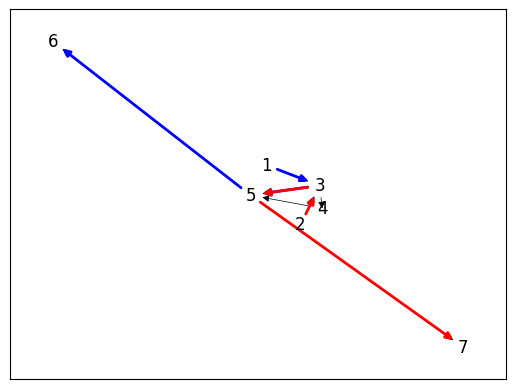

In [36]:
# p = pr.Problem(None, G, ZK = None, ZK_shape=(2,2), c_mode = 2, t_mode= 2)
p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = None, c = c, t_mode= None, t=t)
p.solve(mode="linprog_v1")

In [7]:
G.edges()

OutEdgeView([(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)])

<class 'problem.Linprog_v1'>:
7.0 Optimization terminated successfully. (HiGHS Status 7: Optimal)


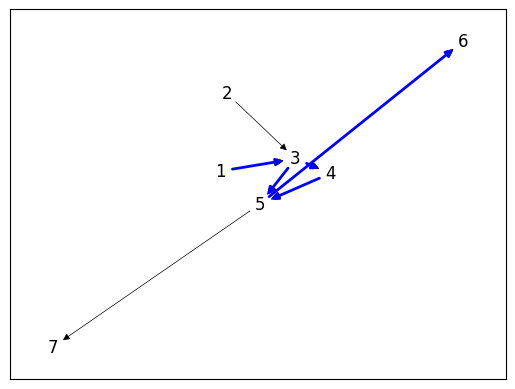

<class 'problem.Linprog_v2'>:
7.0 Optimization terminated successfully. (HiGHS Status 7: Optimal)


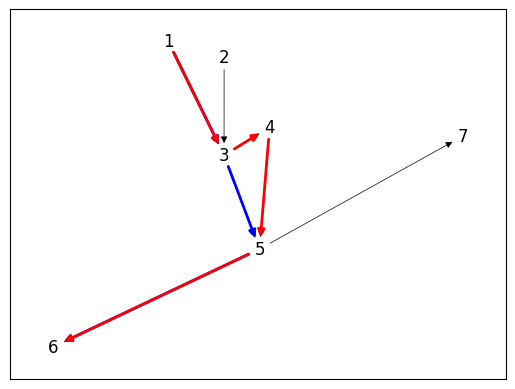

In [16]:
importlib.reload(pr)
ZK = [(1,6,2)]
c = [2,1,1,1,1,2,1]
p = pr.Problem(None, G, ZK = ZK, ZK_shape=None, c_mode = None, c = c, t_mode= None, t=t)
pr.Linprog_v1.solve(p)

pr.Linprog_v2.solve(p, st_alternativ=2)
pr.Problem.draw(p)